<a href="https://colab.research.google.com/github/musandur/ML-Projects/blob/main/test_task_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Intro**

In this work, we are going to predict roofs of given satellite pictures data of houses. To this end, we are going to build and train a Convolutional Neural Network (CNN) model and use it to provide nice and accurate predictions of roofs of houses. This work is organised in the following way.

First, we upload the data, investigate it and split it into train and test datasets.

Second, we build and train our chosen convolutional neural network,

Third and finally, we test our results on the test datasets.


In [1]:
import os
import skimage.io 
import numpy as np
from numpy import expand_dims
import imgaug as ia
from imgaug import augmenters as iaa
import sys


import random
from tqdm import tqdm
from skimage.transform import resize
import matplotlib.pyplot as plt


import tensorflow as tf
import keras
from keras import layers, Model, optimizers
from keras.layers import Add, Input, Conv2D, Conv2DTranspose, MaxPooling2D, Lambda, Dropout, concatenate 
import shutil


>>>>**Upload and and quick investigation the dataset**

In [2]:
#----Authorise and mount my Google drive---#
from google.colab import drive
drive.mount('/content/drive')

#-----Unzip my dataset from GC (Google Colab)----'
!unzip -uq "/content/drive/MyDrive/dida_test_task.zip" -d "/content/drive/MyDrive/"



Mounted at /content/drive


In [3]:
original_dir = '/content/drive/MyDrive/'

In [4]:
# the paths leading to train, label and test sets
path_to_images = os.path.join(original_dir, 'images')  
path_to_test_X =   os.path.join(original_dir, 'test_X') 
path_to_labels = os.path.join(original_dir, 'labels') 

# collect the file names of each dataset
images_names = sorted(next(os.walk(path_to_images))[2], key=lambda x: int(x.split('.')[0]))
test_images_names = sorted(next(os.walk(path_to_test_X))[2], key=lambda x: int(x.split('.')[0]))
labels_names = sorted(next(os.walk(path_to_labels))[2], key=lambda x: int(x.split('.')[0]))


In [5]:
# print all the file names for sanity check
print('Images:\n {} \nTotal images : {}'.format(images_names, len(images_names)))
print()
print('Labels:\n {} \nTotal labels: {}'.format(labels_names, len(labels_names)))
print()
print('Test_X:\n {} \nTotal test images : {}'.format(test_images_names, len(test_images_names)))



Images:
 ['121.png', '241.png', '270.png', '272.png', '274.png', '278.png', '284.png', '287.png', '300.png', '301.png', '303.png', '308.png', '314.png', '315.png', '317.png', '320.png', '324.png', '328.png', '337.png', '343.png', '345.png', '379.png', '381.png', '417.png', '532.png'] 
Total images : 25

Labels:
 ['121.png', '241.png', '270.png', '272.png', '274.png', '278.png', '284.png', '287.png', '300.png', '301.png', '303.png', '308.png', '314.png', '315.png', '317.png', '320.png', '324.png', '328.png', '337.png', '343.png', '345.png', '379.png', '381.png', '417.png', '532.png'] 
Total labels: 25

Test_X:
 ['535.png', '537.png', '539.png', '551.png', '553.png'] 
Total test images : 5


In [6]:
# Verify the dimension (the length of the shape) of the images and the masks
# knowing infromation such as the dimension of the images is crucial because
# In fact, we must know the color channels of the images we are dealing with 

img_dim = []
labels_dim = []
test_img_dim = []
for img_name, label_name in zip(images_names, labels_names):
  img = skimage.io.imread(os.path.join(path_to_images, img_name))
  img_dim.append(len(img.shape))
  label = skimage.io.imread(os.path.join(path_to_labels, label_name))
  labels_dim.append(len(label.shape))

  
print('Images dimension: {}'.format(img_dim))
print()
print('Labels dimension: {}'.format(labels_dim))

for test_name in test_images_names:
  test_img = skimage.io.imread(os.path.join(path_to_test_X, test_name))
  test_img_dim.append(len(test_img.shape))
print()
print('Test images dimension: {}'.format(test_img_dim))


Images dimension: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

Labels dimension: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

Test images dimension: [3, 3, 3, 3, 3]


According to the lists above, it is clear that we are dealing with a **semantic segmention problem** with one class (the white pixels) and the background image class (the black pixels). The labels (masks) are all gray scaled while the images (both train and test) are all colored. Hence, we are going to build and train a deep neural network model that will predict a segmentation roofs captured by a sattelite. That is,  pixelse masks of roofs will be detected and highlighted while the set of pixels off the roofs will be mapped to zero. 

However, since  we have **.png** files, it helps to verify channel size of the image files. Indeed, in many cases we usually notice that the third dimension of a **.png** files is usually 4 and not 3.



In [7]:
img_channels = []
for img_name in images_names:
  img = skimage.io.imread(os.path.join(path_to_images, img_name))
  img_channels.append(img.shape[2])

print('Images dimension: {}'.format(img_channels))

Images dimension: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Before building the model we take the precaution to set the channel size back to 3 instead of 4.

Now, we visualize the training set, the labels and the test set.

Random sample of images: [4, 14, 23, 24, 7]


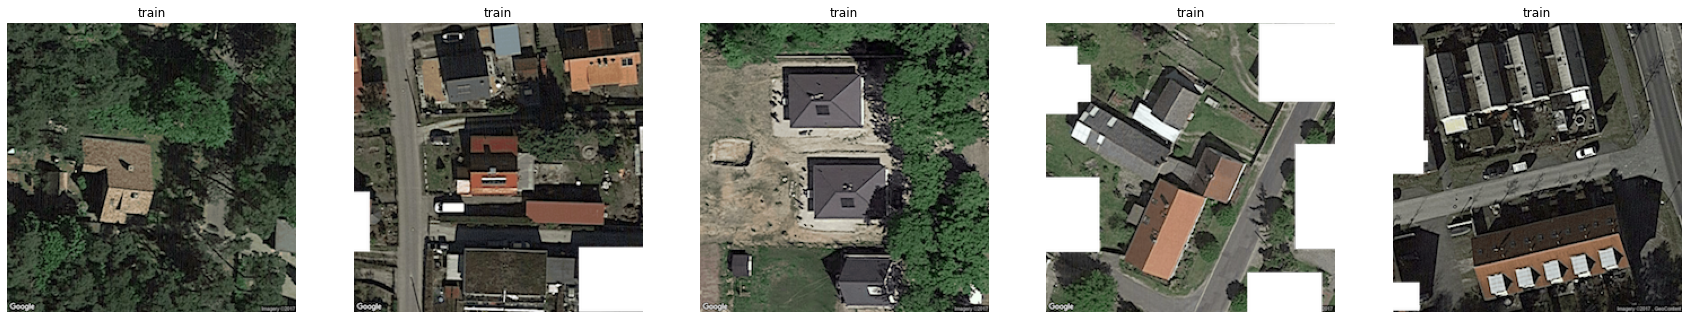

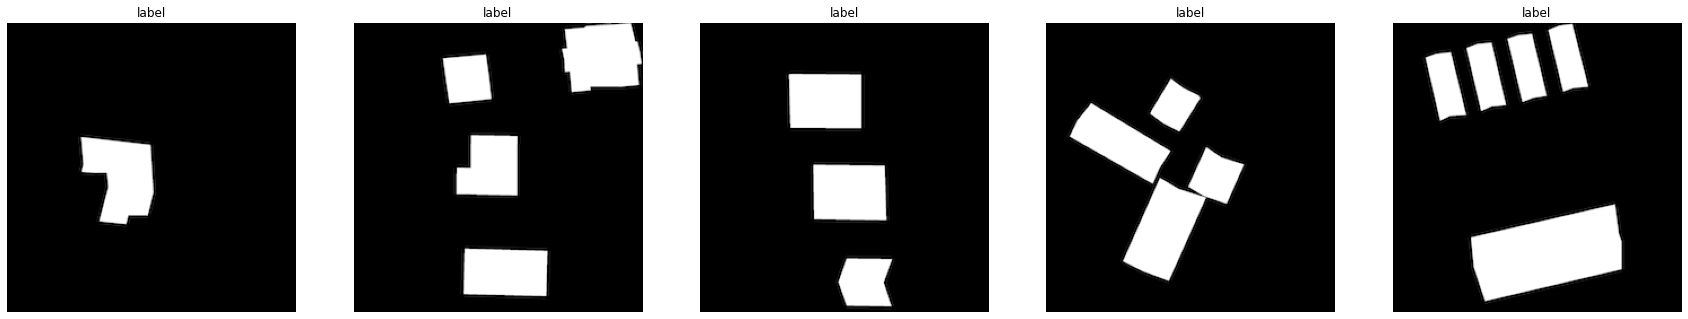

In [8]:
# show the images and their labels
randomlist = random.sample(range(0, 25), 5)
print('Random sample of images: {}'.format(randomlist))

# images
plt.figure(figsize=(30, 30))
k = 0
for i in randomlist:
  plt.subplot(1, 5, k+1)
  img = skimage.io.imread(os.path.join(path_to_images, images_names[i]))
  plt.imshow(img)
  plt.title('train')
  plt.axis('off')
  k +=1
plt.show()

# labels
plt.figure(figsize=(30, 30))
k = 0
for i in randomlist:
  plt.subplot(1, 5, k+1)
  img_l  = skimage.io.imread(os.path.join(path_to_labels, labels_names[i]))
  plt.imshow(np.squeeze(img_l), cmap='gray')
  plt.title('label')
  plt.axis('off')
  k += 1
plt.show()

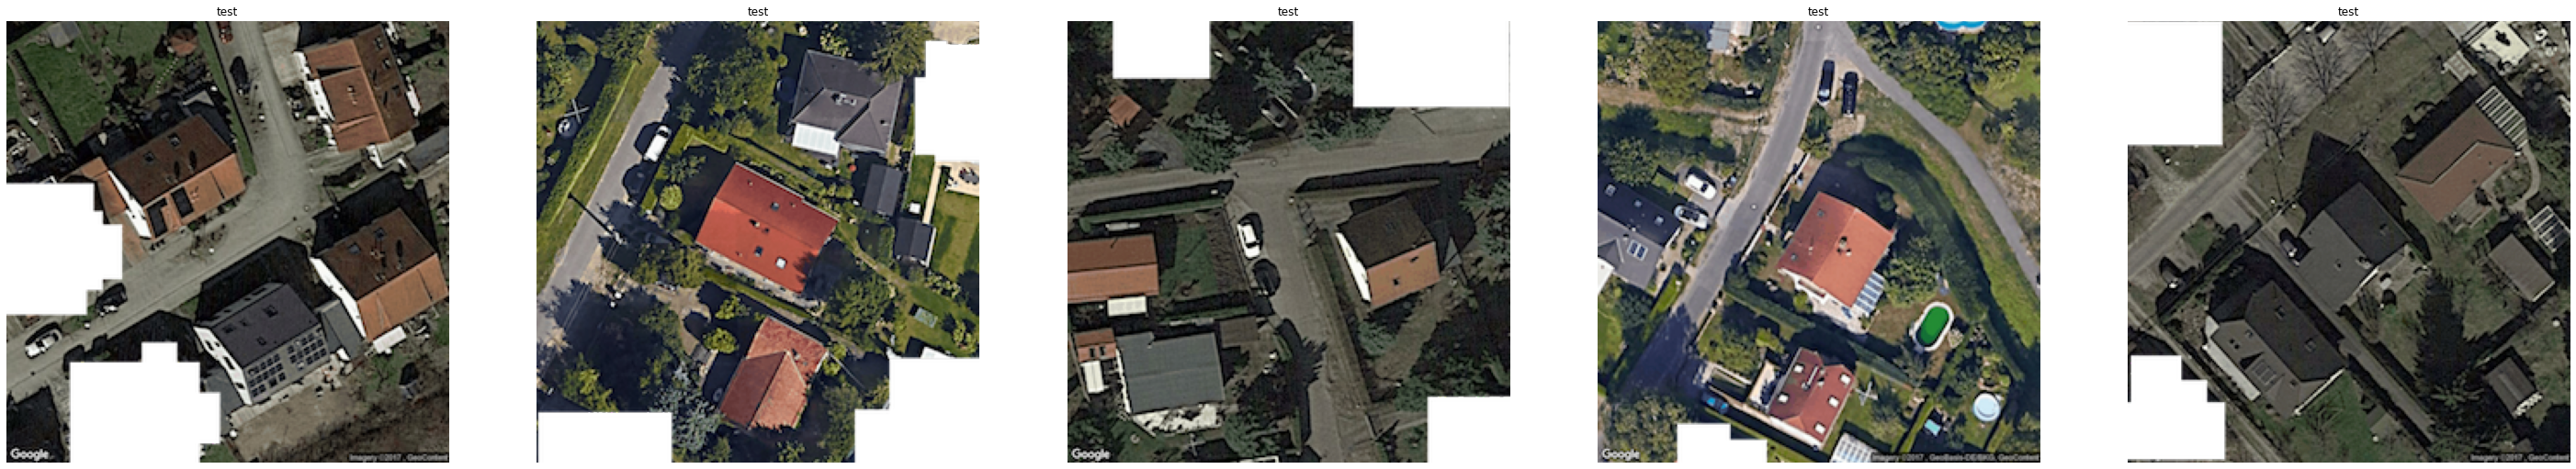

In [9]:
# show test images


# images
plt.figure(figsize=(50, 50))

for i in range(5):
  plt.subplot(1, 5, i+1)
  test_img = skimage.io.imread(os.path.join(path_to_test_X, test_images_names[i]))
  plt.imshow(test_img)
  plt.title('test')
  plt.axis('off')
plt.show()

>>>>> **Building the model:**

 We choose a **U-net** convolutional neural network like architecture . This choice is justified by the fact that the U-net is a convolutional neural network that provides fast and accurate classification of pixels in an image. Note that the output of a semantic segmentation model is an image rather that a numer or a vector. Hence, since the labels we are given are 2D images, it is clear that a **semantic segmentation model architecture must be used to solve this task**. 

Before building and training the CNN model, we are going to set up some prerequisites including a customized **DataGenerator** class, an instance of an an image augmentation class.

In [10]:
# Here we are instanciating a computer vision class for 
# image augmentation
# We randomly apply the following transformations:
# - Horizontal flip
# - brightness
# - some gaussian blurring
# - and rotation 

# These transformation do not alter the content and representation of our images.

ia.seed(1)


seq = iaa.Sequential([
    iaa.Fliplr(0.7),
    iaa.Multiply((1.2, 1.1)),
    iaa.Affine(
        rotate=(-10, 10)
    ),
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 1))
    )
], random_order=True)

seq_det = seq.to_deterministic()



In [11]:
class DataGenerator(tf.keras.utils.Sequence):
  # Generates data for Keras
  def __init__(self, image_paths, label_paths, batch_size=32, shuffle=True, augment=False):
    self.image_paths = image_paths
    self.label_paths = label_paths
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.augment = augment
    self.on_epoch_end()

  def __len__(self):
    # Denotes the number of batches
    return int(np.floor(len(self.image_paths) / self.batch_size))

  def __getitem__(self, index):
    # Generates indexes of the batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    image_paths = [self.image_paths[k] for k in indexes]
    label_paths = [self.label_paths[k] for k in indexes]
    
    X, y = self.__data_generation(image_paths, label_paths)

    return X, y

  def on_epoch_end(self):
    # Updates indexes after each epoch
    self.indexes = np.arange(len(self.image_paths))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)  


  def augment_images(self, image_path, label_path):
    '''
    A custom data augmention tasks.
    It helps build a more robust model.
    It also helps increase the size of our small dataset
    training images are randomly transformed using:
    rotation, hozontal flips, random gaussian blurring and
    brightness

    '''
    # augment the image
    img = skimage.io.imread(image_path)
    img_label = skimage.io.imread(label_path)
    image_aug = seq_det.augment_image(img)
    image_aug_label = seq_det.augment_image(img_label)
    
    return image_aug, image_aug_label

  def __data_generation(self, image_paths, annot_paths):
    X = np.empty((self.batch_size, 256, 256, 3), dtype=np.float32)
    Y = np.empty((self.batch_size, 256, 256, 1), dtype=np.float32)

    for i, (im_path, label_path) in enumerate(zip(image_paths, annot_paths)):
      # read images and their labels
      img = skimage.io.imread(im_path)
      img_labels = skimage.io.imread(label_path)
      img_labels = np.expand_dims(img_labels, axis=2)
      # check for augmentation
      if self.augment:
        img, img_labels = self.augment_images(im_path, label_path)
        # update channels 
      img = img[:,:,:3]
      X[i,] = img
      #Y[i, ] = img_labels[..., None]/255.0
      Y[i, ] = img_labels/255.0


    return X, Y


In [12]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

**The Unet model:**

The U-net model architecture was designed for biomedical image segmentation tasks and the original paper can be found [here](https://arxiv.org/pdf/1505.04597.pdf). Since then, it has remained among one of the most influencial CNN model architecture for semantic segmentation.

In this work, we are going to build a U-net CNN model and show that the latter is very suitable for the problem we are solving here. Indeed, we are going to show that our model provides accurate predictions of roofs of houses spotted from satellite pictures.  

Our CNN model is composed of two symmetric braches: the **contraction or decoding path** and the **expansive or encoding path**. The contraction path has a role of capturing local information while the expansive path yields precise location of **object of interests, including roofs** for instance. This makes the U-net architecture very efficient and fancy as a model. Indeed,  the contraction path learns to capture pixel features information of an input image  including roofs of houses, but, at the same time, it fails to provide their spatial information. That is when the expansive path comes in handy. Indeed the latter will figure out where those features are located. Therefore, the **one to one concatenations** between the blocks of Convolutions in the contraction path and blocks of Convolutions in the expansive path yield a CNN model to be trained for semantic segmentation of an image. In this way, set of filters and their biases are learned for minimizing the loss function. 

In this work, **the contration path** is composed of **5 blocks of 3-by-3 convolutions layers**. Each block is composed of 2 convolutional layers,  one Dropout (for mitigating overfitting) and one **MaxPooling**(for downsampling features and reduce feature size as well). The **padding** is set to 'same' and the **activation fuction** is the rectified linear unit (ReLU)

The **expansive path** is composed of **4 blocks of convolutions 3 by 3 convolutions**. Each block is composed of one transposed convolutional layer or upsampling (recovering larger features), plus a concatenation operation with the corresponding block in the contraction path, plus two convolutional layers with a Dropout. The activation function is also the ReLU and the padding is set to 'same'

Note that the one to one concatenations between blocks do not concern the the fifth block of the contraction path, as this block is the bottom of the U shape of the model architecture

**Hyperparameter choices:**

The loss function is the binary cross entropy as we are dealing with only two classes: the roofs and the backgroud. We choose the Adam() optimizer with a learning rate of $0.001$. We are working with $500$ epochs with mini batch size of $5$. The choice of these hyperparamters will be explained later as comments.

In [13]:
def preprocess_input(x):
    x /= 255.
    return x

def unet(base=4):

    b = base
    i = Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
    s = Lambda(lambda x: preprocess_input(x)) (i)
    n_classes = 1
    # Contraction / encoding path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.3)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.3)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.5)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expansive / decoding path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.3)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.3)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='Same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    o = Conv2D(n_classes, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=i, outputs=o)
    model.compile(optimizer= tf.keras.optimizers.Adam(1e-3), loss= tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy']) 

    model.summary()

    return model

In [14]:
image_paths = [os.path.join(path_to_images, x) for x in images_names]
label_paths =  [os.path.join(path_to_labels, x) for x in labels_names]
test_images_path = [os.path.join(path_to_test_X, x) for x in test_images_names]

In [15]:
model = unet(base=4)

tg = DataGenerator(image_paths=image_paths, label_paths=label_paths, batch_size=5, augment=False)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [16]:
history = model.fit_generator(generator=tg, steps_per_epoch=len(tg), epochs=500, verbose=1)

Epoch 1/500


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


5/5 [==============================] - 19s 56ms/step - loss: 0.6690 - accuracy: 0.5499
Epoch 2/500
5/5 [==============================] - 0s 61ms/step - loss: 0.4861 - accuracy: 0.8319
Epoch 3/500
5/5 [==============================] - 0s 65ms/step - loss: 0.4528 - accuracy: 0.8338
Epoch 4/500
5/5 [==============================] - 0s 59ms/step - loss: 0.4185 - accuracy: 0.8338
Epoch 5/500
5/5 [==============================] - 0s 60ms/step - loss: 0.3705 - accuracy: 0.8338
Epoch 6/500
5/5 [==============================] - 0s 58ms/step - loss: 0.3507 - accuracy: 0.8338
Epoch 7/500
5/5 [==============================] - 0s 60ms/step - loss: 0.3375 - accuracy: 0.8338
Epoch 8/500
5/5 [==============================] - 0s 62ms/step - loss: 0.3771 - accuracy: 0.8338
Epoch 9/500
5/5 [==============================] - 0s 60ms/step - loss: 0.3497 - accuracy: 0.8338
Epoch 10/500
5/5 [==============================] - 0s 58ms/step - loss: 0.3225 - accuracy: 0.8338
Epoch 11/500
5/5 [============

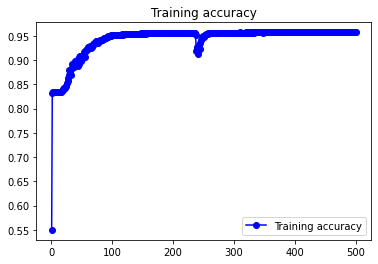

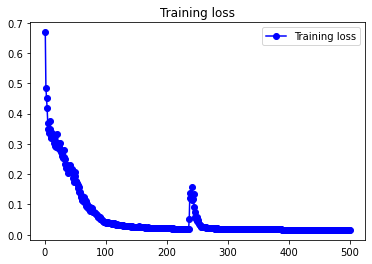

In [17]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.title('Training accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.title('Training loss')
plt.legend()

plt.show()

>>>>>**Predictions**

**Safety Check:**

Check whether model's predictions make sense. We first test the model on the training data, before moving on to the test data.

[3, 2, 9, 13, 20, 4, 5]
1/1 [==============================] - 0s 13ms/step


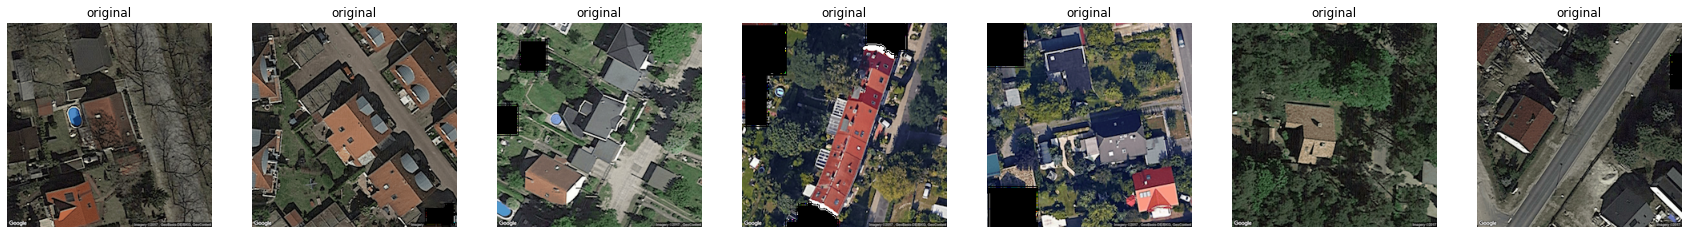

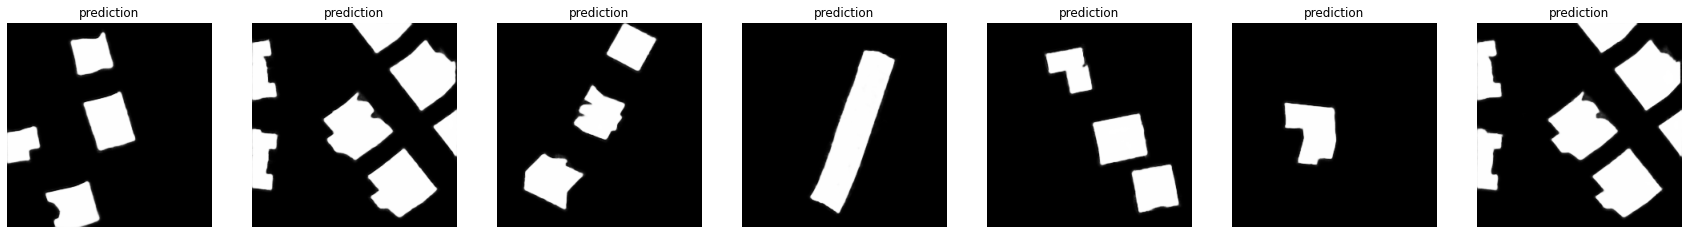

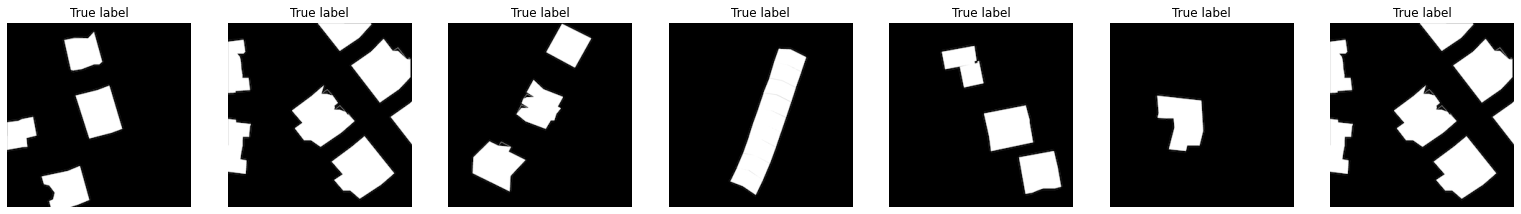

In [18]:
batch_size = 7
XX_val = np.zeros((batch_size, 256, 256, 3))
YY_val = np.zeros((batch_size, 256, 256, 3))
_label = np.zeros((batch_size, 256, 256, 1))

batch = random.sample(range(len(image_paths)), 7)
print(batch)
k = 0
for i in batch:
  img = skimage.io.imread(image_paths[i])
  img1 = img[:,:,:3]/255
  img = img[:,:,:3]
  imgg = np.expand_dims(img, 0)
  preds_train_t = model.predict(imgg, verbose=1)
  XX_val[k] = img1
  YY_val[k] =  preds_train_t[0]

  # labels
  img_label = skimage.io.imread(label_paths[i])
  img1_label = img_label[...,None]/255
  _label[k] = img1_label
  k += 1

plt.figure(figsize=(30, 30))
k = 0
for i in batch:
  plt.subplot(1, 7, k+1)
  plt.imshow(XX_val[k])
  plt.title('original')
  plt.axis('off')
  k += 1
plt.show()

plt.figure(figsize=(30, 30))
k = 0
for i in batch:
  plt.subplot(1, 7, k+1)
  plt.imshow(YY_val[k])
  plt.title('prediction')
  plt.axis('off')
  k += 1
plt.show()


plt.figure(figsize=(27, 27))
k = 0
for i in batch:
  plt.subplot(1, 7, k+1)
  plt.imshow(np.squeeze(_label[k]), cmap='gray')
  plt.title('True label')
  plt.axis('off')
  k += 1
plt.show()

The predictions on training sets are look the same as the true labels/masks. That means that the model has learned very well. Now, we need to test it on the test dataset. 

**Testing our model on the test dataset**

In [19]:
XX_test = np.zeros((len(test_images_path), 256, 256, 3))
YY_test = np.zeros((len(test_images_path), 256, 256, 3))
ZZ_test = np.zeros((len(test_images_path), 256, 256, 3))

for i in range(len(test_images_path)):
  img = skimage.io.imread(test_images_path[i])
  img1 = img[:,:,:3]/255
  XX_test[i] = img1 
  img = img[:,:,:3]
  imgg = np.expand_dims(img, 0)
  preds_train_t = model.predict(imgg, verbose=1)
  preds_train_tt = (preds_train_t >0.09).astype(np.float32)
  YY_test[i] =  preds_train_t[0]
  ZZ_test[i] = preds_train_tt[0]

1/1 [==============================] - 0s 14ms/step


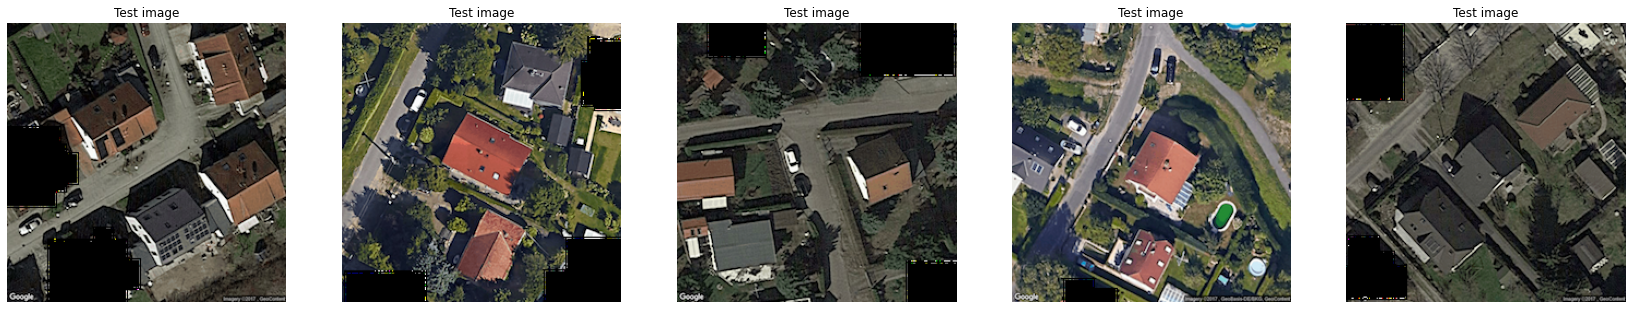

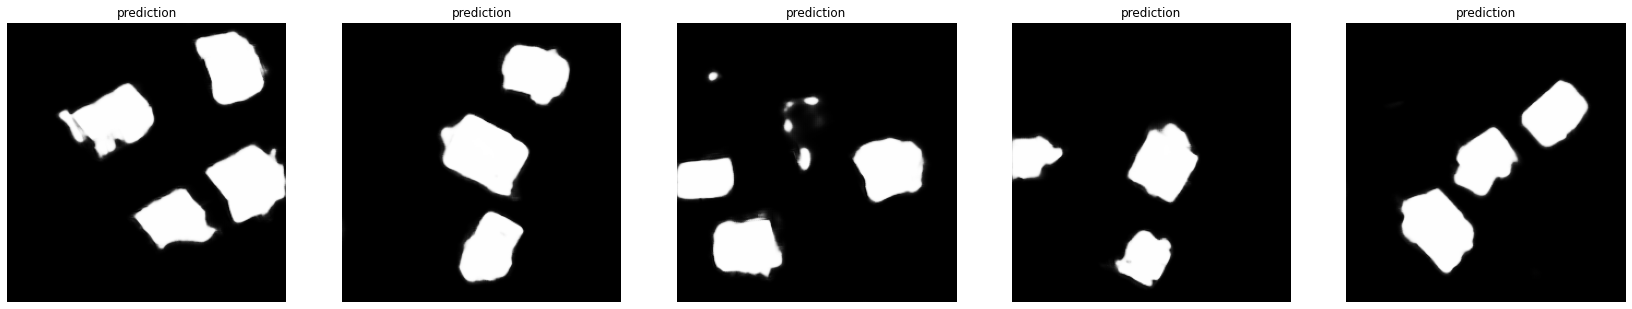

In [20]:
plt.figure(figsize=(29, 29))
for i in range(len(test_images_path)):
  plt.subplot(1, 5, i+1)
  plt.imshow(XX_test[i])
  plt.title('Test image')
  plt.axis('off')
plt.show()

plt.figure(figsize=(29, 29))
for i in range(len(test_images_path)):
  plt.subplot(1, 5, i+1)
  plt.imshow(YY_test[i])
  plt.title('prediction')
  plt.axis('off')
plt.show()



#plt.figure(figsize=(29, 29))
#for i in range(len(test_images_path)):
#  plt.subplot(1, 5, i+1)
#  plt.imshow(ZZ_test[i])
#  plt.title('scaled prediction')
#  plt.axis('off')
#plt.show()




In [21]:
for i in range(5):
  plt.imsave('test_{}'.format(i) + '.png', YY_test[i], cmap = plt.cm.gray)

**Comments:**

In this section, we are going to discuss choices in our problem setting that have led to the successful predictions of roofs of house images from sattelite pictures. 

Hyperparameter choices:
*  we have chosen a batch size of $5$ because this choice is convenient with respect to the small amount of training data (25) that we have in possession. Besides, with batch size of $5$, we have no doubt that we will always have the same number of images (5) in every mini batch for each epoch. Note that a Batch size smaller than $5$ would also work but it will be computationally time consuming as it increases the number of the for loop iterations on mini batches.

*  One may also notice that we have implemented a data augmentation procedure but we turned it off (False) during training. That is beacuse the data augmention was not helpful in making accurate predictions. Indeed, It is well known that data augmentation is very suitable when dealing with small amount of data. However, in this problem, we have noticed that with the data augmentation, our model started to learned irrelevant features (example cars next to houses) besides the roofs. 

*  Randomly reshuffling the batch indexes after each epoch is very suitable when it is combined with a relatively large number of epoch (500). In this way, we teach the model by showing it every possible combination of data. 

*   The choice of the learning rate to $ \alpha = 0.001$ is just convenient for us to get the expected results. Indeed, deep learning models are probelem specific rather than general.






**Discussion:**

We are open to engage in any discussion regarding our approach.